# TalkingData AdTracking Fraud Detection Challenge

Our task parallels this earlier problem: determining whether a user's activity signifies genuine behavior or fraudulent actions. 

Examining the evaluation criteria, the competition employs the ROC-AUC metric, representing the area under a Receiver Operator Characteristic curve. In simpler terms:

Our task involves binary classification, distinguishing between "fraudulent" and "not fraudulent" clicks.
Unlike metrics like LogLoss, AUC prioritizes the ability to effectively differentiate between the two classes, where the prediction order holds significance.
To delve into the dataset effectively, let's begin by exploring the provided data.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import mlcrate as mlc
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pal = sns.color_palette()

print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
sample_submission.csv         195.58MB
train_sample.csv              4.08MB
test_supplement.csv           2665.54MB
train.csv                     7537.65MB
test.csv                      863.27MB


In [2]:
import subprocess
print('# Line count:')
for file in ['train.csv', 'test.csv', 'train_sample.csv']:
    lines = subprocess.run(['wc', '-l', '../input/{}'.format(file)], stdout=subprocess.PIPE).stdout.decode('utf-8')
    print(lines, end='', flush=True)

# Line count:
184903891 ../input/train.csv
18790470 ../input/test.csv
100001 ../input/train_sample.csv


For this analysis, I'm going to use the first 1M rows of the training dataset.

## Data overview

In [3]:
df_train = pd.read_csv('../input/train.csv', nrows=1000000)
df_test = pd.read_csv('../input/test.csv', nrows=1000000)

In [4]:
print('Training set:')
df_train.head()

Training set:


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [5]:
print('Test set:')
df_test.head()

Test set:


,click_id,ip,app,device,os,channel,click_time
0,0,5744,9,1,3,107,2017-11-10 04:00:00
1,1,119901,9,1,3,466,2017-11-10 04:00:00
2,2,72287,21,1,19,128,2017-11-10 04:00:00
3,3,78477,15,1,13,111,2017-11-10 04:00:00
4,4,123080,12,1,13,328,2017-11-10 04:00:00


### Looking at the columns

According to the data page, our data contains:

* `ip`: ip address of click
* `app`: app id for marketing
* `device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* `os`: os version id of user mobile phone
* `channel`: channel id of mobile ad publisher
* `click_time`: timestamp of click (UTC)
* `attributed_time`: if user download the app for after clicking an ad, this is the time of the app download
* `is_attributed`: the target that is to be predicted, indicating the app was downloaded

**A few things of note:**
* If you look at the data samples above, you'll notice that all these variables are encoded - meaning we don't know what the actual value corresponds to - each value has instead been assigned an ID which we're given. This has likely been done because data such as IP addresses are sensitive.
* The `attributed_time` variable is only available in the training set - it's not immediately useful for classification but it could be used for analysis.

For each of our encoded values, let's look at the number of unique values:

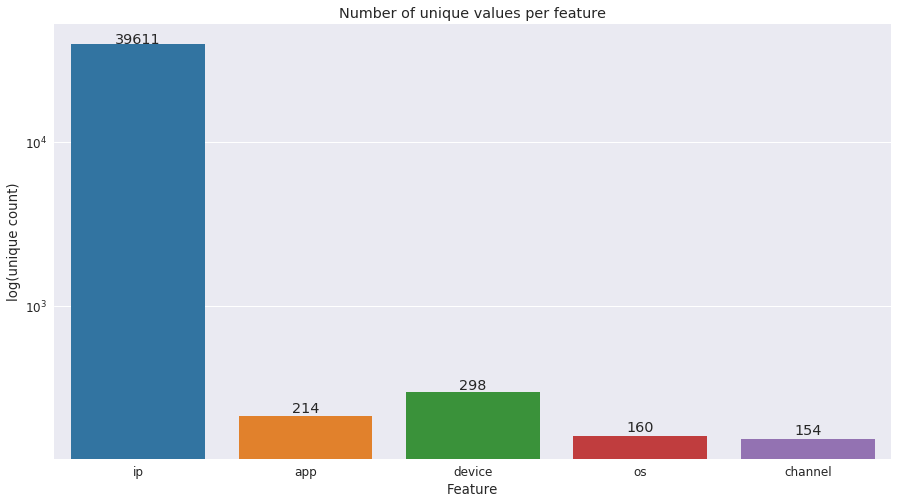

In [6]:
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(df_train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette=pal, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 
# for col, uniq in zip(cols, uniques):
#     ax.text(col, uniq, uniq, color='black', ha="center")

##  Encoded variables statistics

Although the actual values of these variables aren't helpful for us, it can still be useful to know what their distributions are. Note these statistics are computed on 1M samples, and so will be higher for the full dataset.

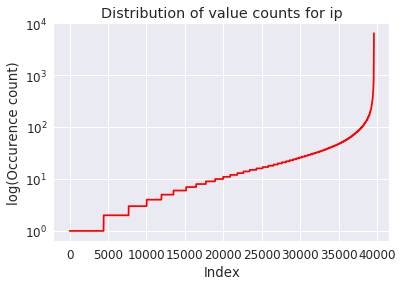

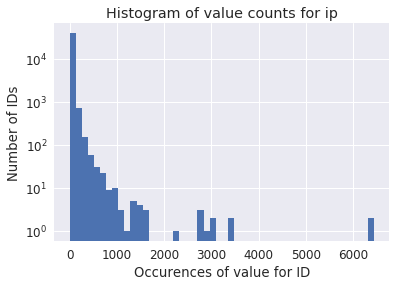

Variable 'ip': | Unique values: 39611 | Count of most common: 6437 | Count of least common: 1 | count>10: 49.56% | count>100: 3.98% | count>1000: 0.07%


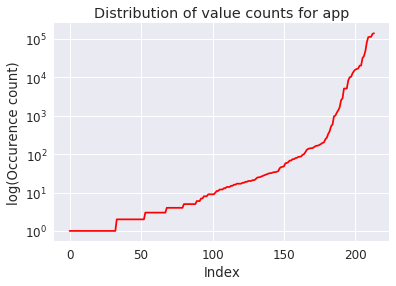

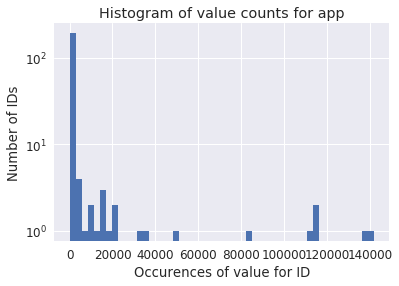

Variable 'app': | Unique values: 214 | Count of most common: 141851 | Count of least common: 1 | count>10: 51.87% | count>100: 22.9% | count>1000: 13.08%


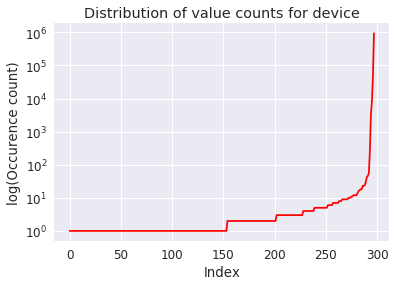

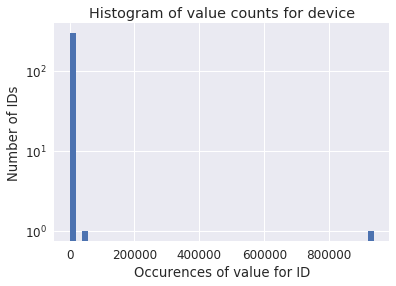

Variable 'device': | Unique values: 298 | Count of most common: 938053 | Count of least common: 1 | count>10: 7.72% | count>100: 1.68% | count>1000: 1.34%


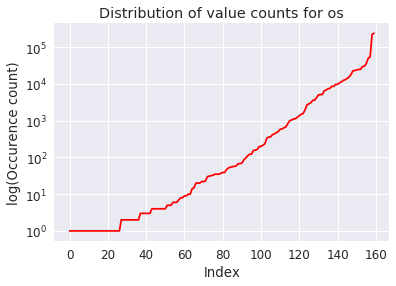

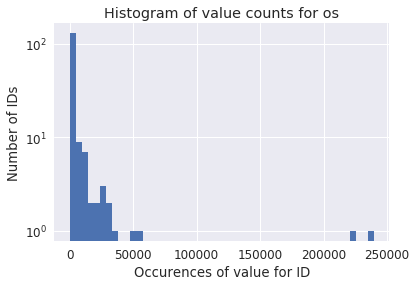

Variable 'os': | Unique values: 160 | Count of most common: 239642 | Count of least common: 1 | count>10: 60.0% | count>100: 41.88% | count>1000: 28.12%


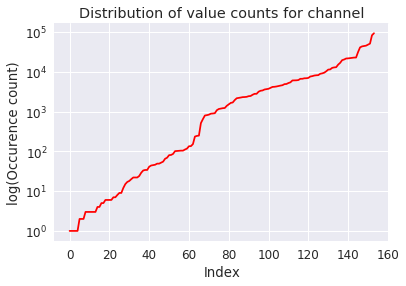

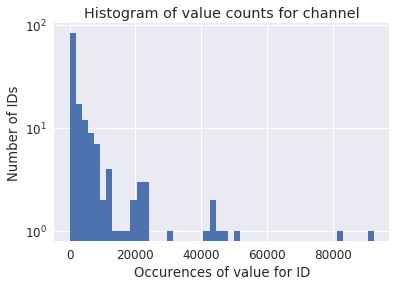

Variable 'channel': | Unique values: 154 | Count of most common: 92534 | Count of least common: 1 | count>10: 82.47% | count>100: 65.58% | count>1000: 51.95%


In [7]:
for col, uniq in zip(cols, uniques):
    counts = df_train[col].value_counts()

    sorted_counts = np.sort(counts.values)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    line, = ax.plot(sorted_counts, color='red')
    ax.set_yscale('log')
    plt.title("Distribution of value counts for {}".format(col))
    plt.ylabel('log(Occurence count)')
    plt.xlabel('Index')
    plt.show()
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.hist(sorted_counts, bins=50)
    ax.set_yscale('log', nonposy='clip')
    plt.title("Histogram of value counts for {}".format(col))
    plt.ylabel('Number of IDs')
    plt.xlabel('Occurences of value for ID')
    plt.show()
    
    max_count = np.max(counts)
    min_count = np.min(counts)
    gt = [10, 100, 1000]
    prop_gt = []
    for value in gt:
        prop_gt.append(round((counts > value).mean()*100, 2))
    print("Variable '{}': | Unique values: {} | Count of most common: {} | Count of least common: {} | count>10: {}% | count>100: {}% | count>1000: {}%".format(col, uniq, max_count, min_count, *prop_gt))
    

## Understanding the target variable

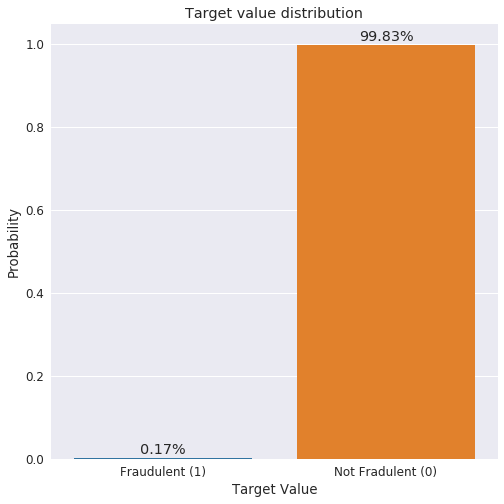

In [8]:
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (df_train.is_attributed.values == 1).mean()
ax = sns.barplot(['Fraudulent (1)', 'Not Fradulent (0)'], [mean, 1-mean], palette=pal)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height+0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

The dataset is unbalanced. Only 0.2% of the dataset is made up of fradulent clicks. This means that any models we run on the data will either need to be robust against class imbalance or will require some data resampling.